# Operational Radar Tutorial

## Introduction

So far we've learnt how to estimate rain rate from reflectivity and generate Cartesian gridded radar data.
In this tutorial we will expand these skills by retrieving hail size from reflectivity and producing maps that show maximum hail size across an entire event.
These procedures are the first steps to generating long-term gridded climatology products (of any variable) that can extend across decades.
Finally, a simple pyart tool for exporting grids into geotif will be demonstrated.

Here's an example of what you can achieve using gridded climatologies (8 year MESH-based climatology for Sydney and Brisbane) from [Warren et al. 2020](https://rmets.onlinelibrary.wiley.com/doi/10.1002/qj.3693)

<img align="left" width="800" height="800" src="img/warren2020.png" border="5">


## Hail Size Retrieval

One of the most commonly used hail size retrievals is the Maximum Estimated Size of Hail (MESH). This technique was first introduced by [Witt et al. 1998.](https://journals.ametsoc.org/view/journals/wefo/13/2/1520-0434_1998_013_0286_aehdaf_2_0_co_2.xml) and more recently updated by [Muillo and Homeyer 2019](http://weather.ou.edu/~chomeyer/assets/murillo---homeyer-2019.pdf). It can be applied to any volumetric dataset which contains reflectivity (including level 1 of the operational radar archive). The MESH technique also requires the altitude of the 0C and -20C isotherms. Hail size is estimated by using a weighted (by Z and T) integration of the vertical reflectivity column above the freezing level. It's considered a fairly crude technique, but still provides reasonable skill in most cases.

This retrieval along with polarimetric hail size retrievals is available in the [PyHail](https://github.com/joshua-wx/PyHail) library. For this tutorial, the file containing the MESH implementation (mesh.py) has been copied into the tutorial folder.

<img align="left" width="400" height="400" src="img/mesh.png" border="5">

In [11]:
#First, let's use the scripts from Part 3 of the Introduction to load up hailstorm case for Brisbane

import os #used for system commands
import tempfile #used to create temporary folders to store data
import zipfile #used to extract tar files
import urllib #used to download data via http
from glob import glob #used for manipulating pathnames

from matplotlib import pyplot as plt #plotting toolkit
import cartopy.crs as ccrs
import numpy as np
import pyart #python radar toolkit

from tqdm import tqdm

import mesh #from the pyhail library

import warnings
warnings.simplefilter("ignore")

"""
#############################################################
#
# Options to define our data selection
#
#############################################################
"""

#Specific the radar and date we want to download
radar_id     = '50' #this is the Marburg radar near Brisbane. if using a single digit, include a leading 0, e.g., '02'. Complete list of radar id's is on openradar.io
date_str     = '20201031' #in yyyymmdd
base_url     = 'http://dapds00.nci.org.au/thredds/fileServer/rq0' #base url for NCI server

"""
#############################################################
#
# Here we build the server request url, download data and unzip
#
#############################################################
"""

#step 1: build request url and download zip file
zip_fn       = radar_id + '_' + date_str + '.pvol.zip'
request_url  = '/'.join([base_url, radar_id, date_str[0:4], 'vol', zip_fn])
print('my request is ',request_url)
#download the zip file
urllib.request.urlretrieve(request_url, zip_fn)

#step 2: extract the zip file to a temporary directory
temp_dir = tempfile.mkdtemp()
zip_fh = zipfile.ZipFile(zip_fn)
zip_fh.extractall(path = temp_dir)
zip_fh.close()

#step 3: list all the volumes extracted from the zip file
file_list = sorted(glob(temp_dir + '/*'))
#remove zip
os.system('rm ' + zip_fn)
print('data download complete')

my request is  http://dapds00.nci.org.au/thredds/fileServer/rq0/50/2020/vol/50_20201031.pvol.zip
data download complete


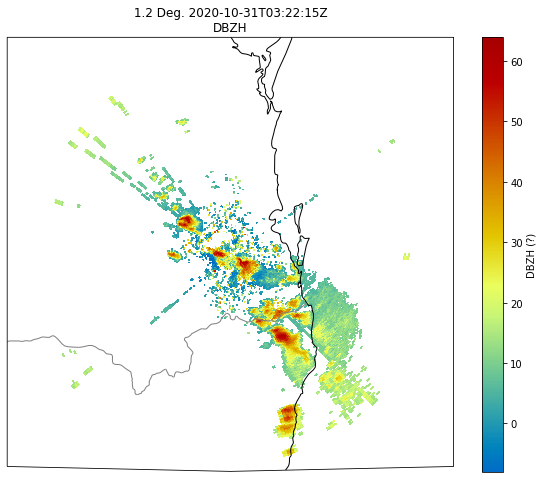

In [8]:
"""
#############################################################
#
# Select a file from the list and plot reflectivity PPI
#
#############################################################
"""

#select index from file list
my_index = 20
#read in radar object using pyart
radar = pyart.aux_io.read_odim_h5(file_list[my_index], file_field_names=True)
#unforuntately the radar lat and lon are missing, so we need to add these
radar.latitude['data'] = np.array([-27.608])
radar.longitude['data'] = np.array([152.539])
radar.altitude['data'] = np.array([371.06])

#generate display object
display = pyart.graph.RadarMapDisplay(radar)
#plot reflectivity field from a single tilt (this function includes a basemap)
fig = plt.figure(figsize=(10, 8), facecolor='w')
display.plot_ppi_map('DBZH', 1,
                            vmin=-8, vmax=64, cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                            resolution='10m')

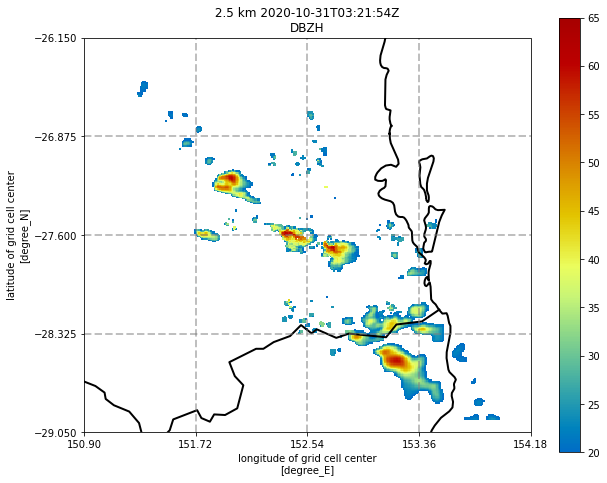

In [9]:
"""
#############################################################
#
# interpolate radar volume onto a Cartesian grid and plot grid
#
#############################################################
"""

grid = pyart.map.grid_from_radars(radar, grid_shape=(41, 301, 301),
                                  grid_limits=((0, 20e3), (-150e3, 150e3), (-150e3, 150e3)),
                                  weighting_function='Barnes2')
#and plot our gridded radar dataset
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
grid_display = pyart.graph.GridMapDisplay(grid)
grid_display.plot_grid('DBZH',level=5, vmin=20, mask_outside=True) #level=5 is the 6th slice in the 3D interpolated field (2.5 km altitude)

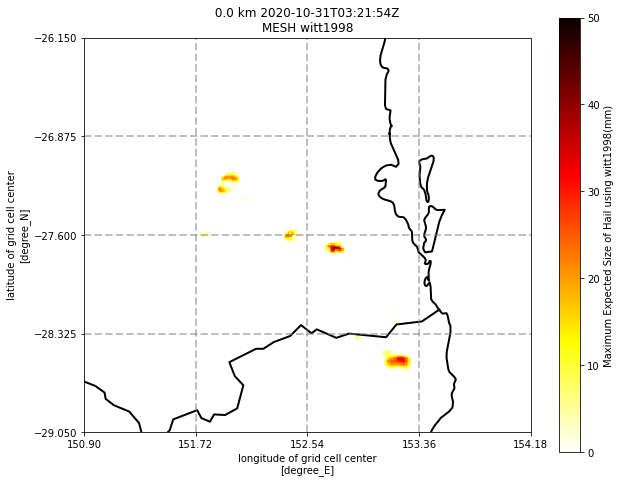

In [10]:


#For the case of demonstration, let's define the 0C and -20C levels to be 3500m and 7000m respectively. 
#This data is normally extracted from a sounding
grid = mesh.main(grid, 'DBZH', temph_data=[3500,7000], mesh_method='witt1998')
#and plot
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
grid_display = pyart.graph.GridMapDisplay(grid)
#note: MESH is a 2D field, and is stored in the first level of the 3D MESH field
grid_display.plot_grid('mesh_witt1998',0, vmin=0, vmax=50, cmap='hot_r')

In [12]:
"""
#############################################################
#
# Next step is to produce these MESH grids for every radar volume during the event,
# and create a maximum mesh field across all of these timesteps.
# This is the first step towards producing a grid-based climatology!
#
#############################################################
"""

#let's define a range of indices to use (this can be ignored if you want to process the entire day)
start_index = 10
end_index = 30

#create an empty grid to store climatology
acc_mesh = np.zeros([301,301])

for i in tqdm(range(start_index, end_index+1), total=end_index-start_index):
    #read in radar object using pyart
    radar = pyart.aux_io.read_odim_h5(file_list[i], file_field_names=True)
    #unforuntately the radar lat and lon are missing, so we need to add these :(. This is normally not the case.
    radar.latitude['data'] = np.array([-27.608])
    radar.longitude['data'] = np.array([152.539])
    radar.altitude['data'] = np.array([371.06])
    #Next, let's interpolate this onto a Cartesian grid
    grid = pyart.map.grid_from_radars(radar, grid_shape=(41, 301, 301),
                                      grid_limits=((0, 20e3), (-150e3, 150e3), (-150e3, 150e3)),
                                      weighting_function='Barnes2')
    #For the case of demonstration, let's define the 0C and -20C levels to be 3500m and 7000m respectively.
    #retrieve MESH
    grid = mesh.main(grid, 'DBZH', temph_data=[3500,7000], mesh_method='witt1998')
    #take the maximum of the accumulated mesh field and the instantenous field
    acc_mesh = np.amax(np.stack((acc_mesh, grid.fields['mesh_witt1998']['data'][0,:,:]), axis=2), axis=2)

21it [00:51,  2.44s/it]                        


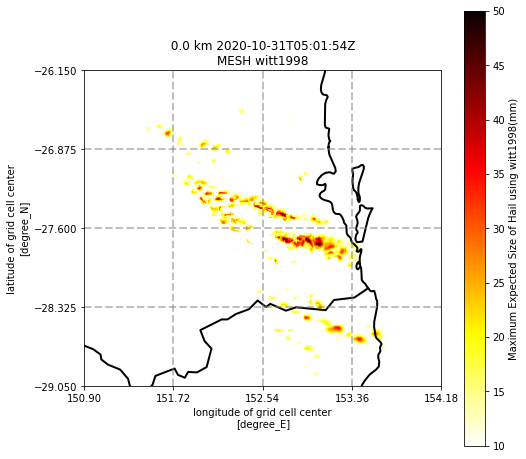

In [14]:
"""
#############################################################
#
# Now to plot the accumulate MESH field.
# A short cut is to reinsert it into the grid object so we can use the pyart plotting functions
#
#############################################################
"""

#first, let's copy our mesh field from the last grid object generated
grid.add_field('acc_mesh', grid.fields['mesh_witt1998'].copy(), replace_existing=True)
#insert acc_mesh into the first level.
grid.fields['acc_mesh']['data'][0,:,:] = acc_mesh

#plot acc_mesh
grid_display = pyart.graph.GridMapDisplay(grid)
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
grid_display.plot_grid('acc_mesh',0, vmin=10, vmax=50, cmap='hot_r', mask_outside=True)

In [15]:
"""
#############################################################
#
# Finally, we can output the MESH field as a geotif for use in GIS software (e.g., QGIS or ArcGIS)
#
#############################################################
"""
#export the first level of acc_mesh
pyart.io.write_grid_geotiff(grid, 'mesh_acc_20201031_Marburg.tif', 'acc_mesh', level=0)
#Note!: the radar grid Azimuthal Equidistant projection is wrapped onto a WGS84 lat/lon grid centre on the radar origin.
#To use a projection, see this pyart help - https://arm-doe.github.io/pyart/API/generated/pyart.io.write_grid_geotiff.html

In [25]:
"""
#############################################################
#
# Now it's your go...
# using the code snippet below for estimating rain rate from reflectivity, create an maximum rain rate map for the event.
#
#############################################################
"""
# read reflectivity data from radar dataset (unit: dBZ)
dbz       = radar.fields['DBZH']['data'][:].copy()
# Convert to reflectivity factor Z (unit: mm6/m3)
z         = 10.**(np.asarray(dbz)/10.)
# Calculate rain rate using standard coefficents according to Marshall-Palmer is a=200., b=1.6
rain_rate = (z / 200) ** (1.0 / 1.6)
# build pyart field, starting with the default, add to radar object
rain_rate_field = pyart.config.get_metadata('rain_rate')
rain_rate_field['data'] = rain_rate
radar.add_field('rain_rate', rain_rate_field, replace_existing=True)

# Next step:
# using the loop example for the mesh grid map, replace the MESH retrieval with the rain rate retrieval
# You will notice the rain rates are too high within the hailstorm cores - this is due to the presence of hail.

## Summary

When processing longer datasets, consideration is need for the compute requirements (e.g., using Dask for multiprocessing and splitting task in many jobs). We use many hundreds of jobs when processing large datasets.

Also, care needs to be taken to ensure absolute radar calibration is correct and ground clutter (which is more of an issue for rain rates) is removed.

Finally, you'll notice that the hail swaths on the event maps are not continous. This is due a combination of the fast moving nature of hailstorms 
during this event and the relatively slow scan time of Marburg radar (10 minutes between volumes). Correcting for this 'advection' between radar volumes
is an important step for any grid-based climatology. The most commonly used package to achive this is [PySteps](https://pysteps.github.io/). Most advection correction techniques implemented in PySteps use a Optical Flow technique to first estimate the motion of the field, then linear interpolation to advect the field between timesteps.

The [advection correction](https://pysteps.readthedocs.io/en/latest/auto_examples/advection_correction.html#sphx-glr-auto-examples-advection-correction-py) demo in PySteps is an ideal first step towards archiving this.

<img align="left" width="800" height="400" src="img/advection.png" border="5">